In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import cv2 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
paths = {
    'train': r'E:\Hiring assignments\Dataset for DS Assignment\images\train',
    'test': r'E:\Hiring assignments\Dataset for DS Assignment\images\final test',
    'val': r'E:\Hiring assignments\Dataset for DS Assignment\images\validation'
}

categories = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

filenames_list = []
categories_list = []

for category in categories:
    path = os.path.join(paths['train'], categories[category])
    filenames = os.listdir(path)
    for filename in filenames:
        filenames_list.append(os.path.join(categories[category], filename))
    categories_list = categories_list + [category]*len(filenames)

df = pd.DataFrame({'filename': filenames_list, 'category': categories_list})
df = df.sample(frac = 1).reset_index(drop=True)

df

,filename,category
0,angry\10401.jpg,0
1,surprise\24832.jpg,6
2,angry\32150.jpg,0
3,surprise\30368.jpg,6
4,sad\15619.jpg,5
...,...,...
26916,sad\22286.jpg,5
26917,surprise\31612.jpg,6
26918,sad\32124.jpg,5
26919,angry\19788.jpg,0


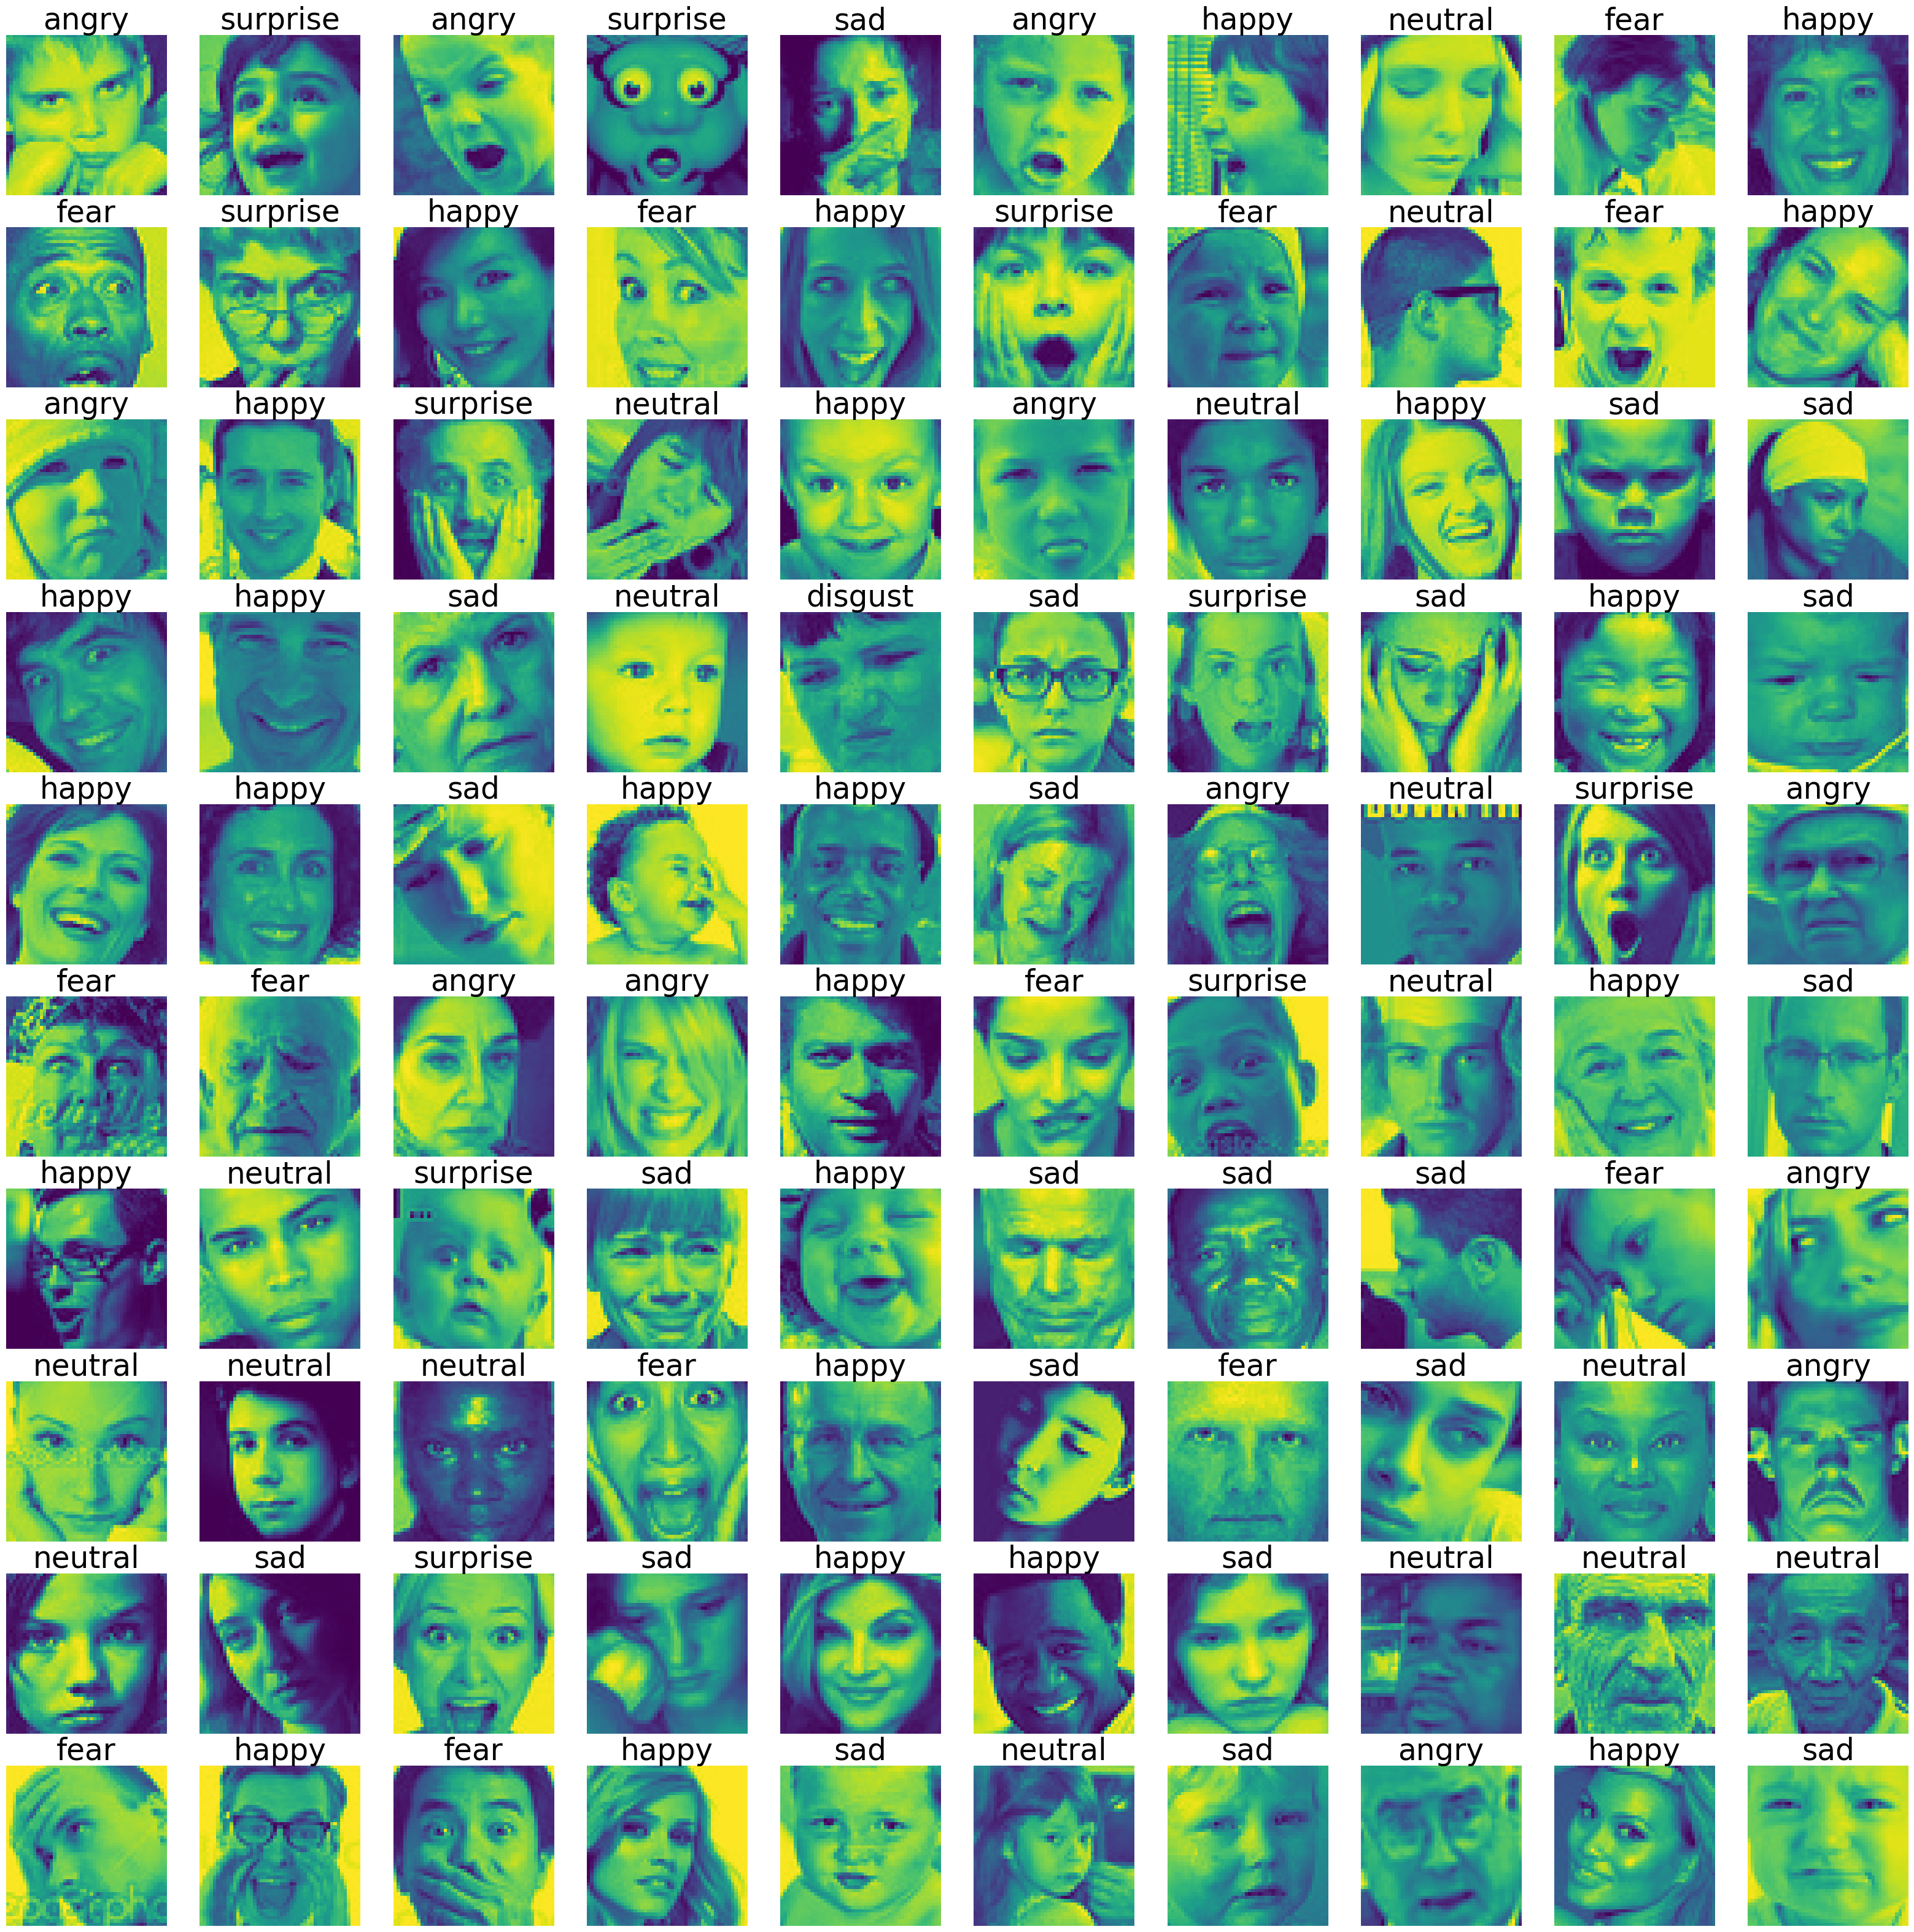

In [7]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = os.path.join(paths['train'], df.filename[i])
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35)
    plt.axis("off")

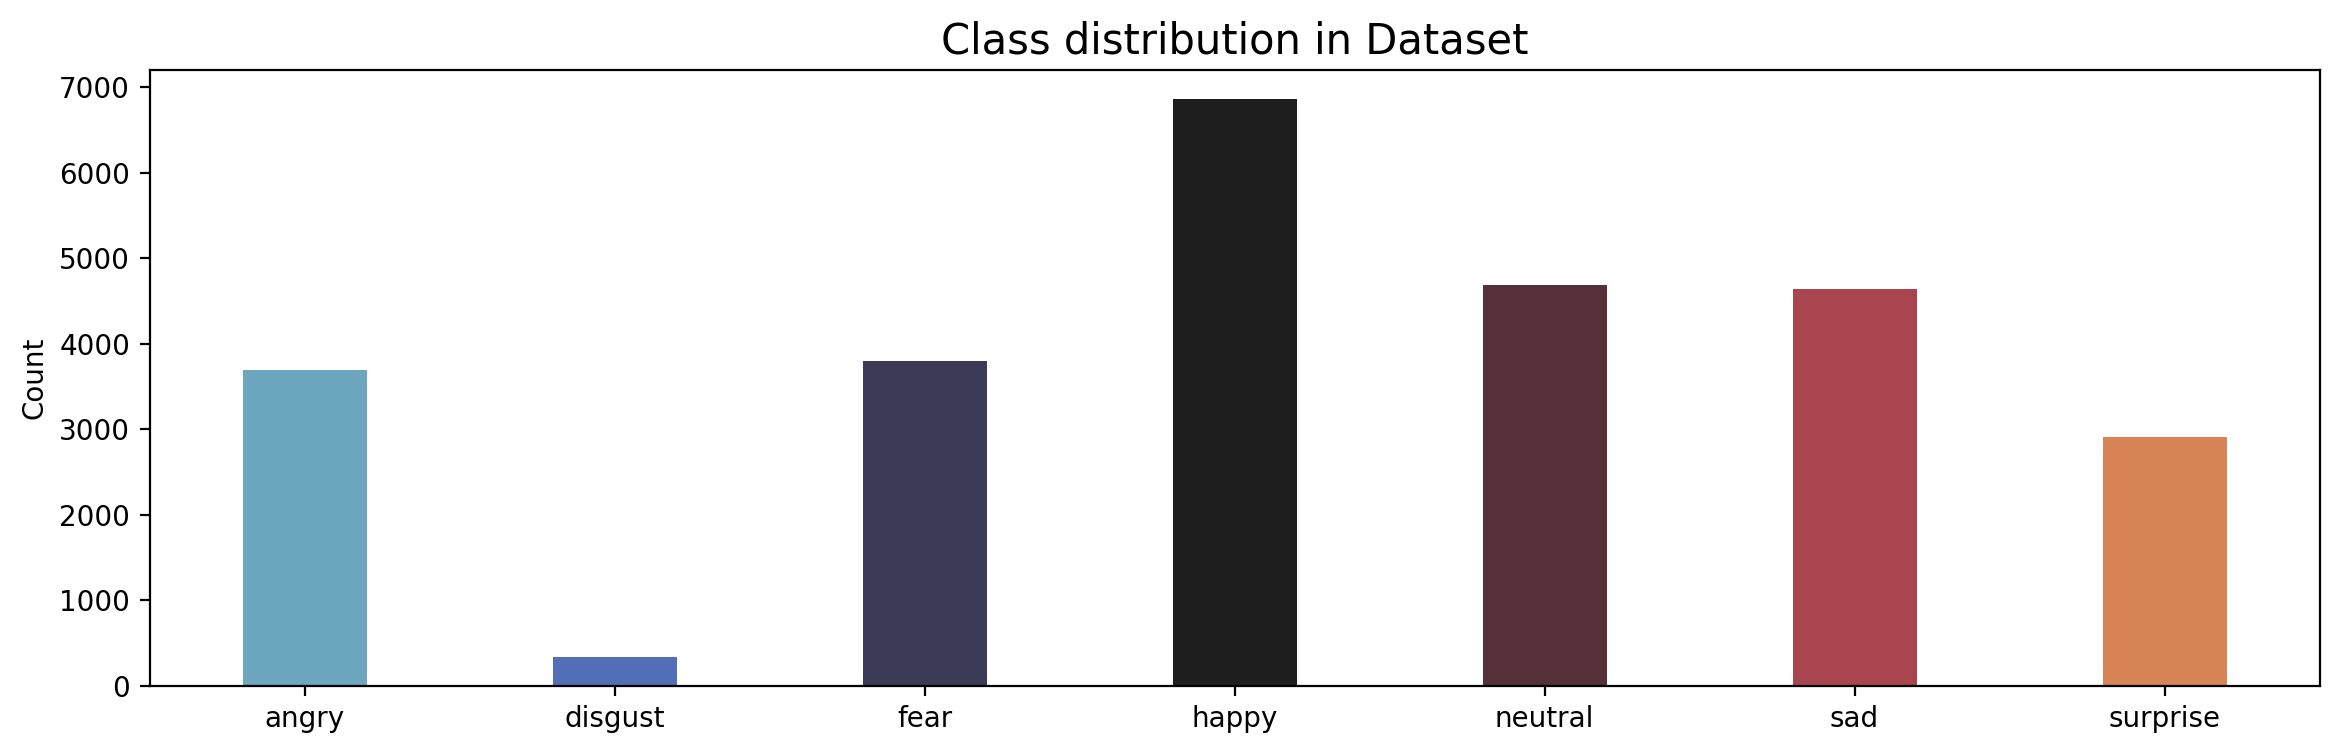

In [5]:
label, count = np.unique(df.category, return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [6]:
datagen = ImageDataGenerator(rescale = 1.0/255)

In [43]:
train_path = paths['train']
test_path = paths['test']
val_path = paths['val']

batch_size = 128
image_size = 48
img_channel = 1
n_classes = 7

In [44]:
train_data = datagen.flow_from_directory(train_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

test_data = datagen.flow_from_directory(test_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

val_data = datagen.flow_from_directory(val_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

Found 26921 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [49]:
inp = tf.keras.layers.Input(shape=(image_size,image_size,img_channel))

model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(inp)
#model = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

#model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

#model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

model = tf.keras.layers.Flatten()(model)

model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dropout(0.2)(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(0.3)(model)

out = tf.keras.layers.Dense(n_classes, activation='softmax')(model)

model = tf.keras.Model(inputs = [inp], outputs = out)

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_45 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 11, 11, 128)      0         
 g2D)                                                      

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta= 0.001,
                                                  patience=5,
                                                  restore_best_weights=True,
                                                  verbose=0)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience = 2,
                                                            factor = 0.5,
                                                            verbose=0)

In [51]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [52]:
expression_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=50,
                      callbacks= [early_stopping, reduce_learning_rate],
                      verbose = 1)

Epoch 1/50
211/211 [==============================] - 1060s 5s/step - loss: 1.7982 - accuracy: 0.2542 - val_loss: 1.6852 - val_accuracy: 0.3353 - lr: 0.0010
Epoch 2/50
211/211 [==============================] - ETA: 0s - loss: 1.5769 - accuracy: 0.3816

KeyboardInterrupt: 

In [16]:
loss,acc = model.evaluate(test_data , verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 49.263158440589905
The Loss of the model for testing data is: 1.3399251699447632
